In [47]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from datetime import datetime
import seaborn as sns


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score,
    f1_score, accuracy_score, classification_report, roc_curve, auc
)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, label_binarize

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from itertools import product


# NLTK downloads (à lancer une seule fois)
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')

In [2]:
CATEGORY_MAPPING = {
    # Fiction
    'fiction': 'Fiction',
    'english fiction': 'Fiction',
    'american fiction': 'Fiction',
    'detective and mystery stories': 'Fiction',
    '"childrens stories"': 'Fiction',

    # Juvenile
    'juvenile fiction': 'Juvenile',
    'juvenile nonfiction': 'Juvenile',
    'young adult nonfiction': 'Juvenile',
    'childrens stories': 'Juvenile',

    # Religion & Spirituality
    'religion': 'Religion & Spirituality',
    'spirit': 'Religion & Spirituality',
    'bibles': 'Religion & Spirituality',
    'bible': 'Religion & Spirituality',

    # Biography
    'biography': 'Biography',
    'autobiography': 'Biography',
    'true crime': 'Biography',

    # Health & Wellness
    'body, mind': 'Health & Wellness',
    'health': 'Health & Wellness',
    'fitness': 'Health & Wellness',
    'relationships': 'Health & Wellness',
    'family': 'Health & Wellness',
    'self-help': 'Health & Wellness',
    'medical': 'Health & Wellness',

    # Business & Economics
    'business': 'Business & Economics',
    'economics': 'Business & Economics',

    # Social Sciences
    'social science': 'Social Sciences',
    'political science': 'Social Sciences',
    'philosophy': 'Social Sciences',
    'psychology': 'Social Sciences',
    'disciplines': 'Social Sciences',
    'law': 'Social Sciences',

    # History
    'history': 'History',
    'great britain': 'History',

    # Computers & Tech
    'computers': 'Computers & Tech',
    'technology': 'Computers & Tech',
    'engineering': 'Computers & Tech',

    # Science & Nature
    'science': 'Science & Nature',
    'nature': 'Science & Nature',
    'mathematics': 'Science & Nature',
    'animals': 'Science & Nature',

    # Cooking
    'cooking': 'Cooking',

    # Recreation & Sports
    'recreation': 'Recreation & Sports',
    'sports': 'Recreation & Sports',
    'games': 'Recreation & Sports',
    'hobbies': 'Recreation & Sports',
    'crafts': 'Recreation & Sports',

    # Education & Language
    'language arts': 'Education & Language',
    'education': 'Education & Language',
    'study aids': 'Education & Language',
    'foreign language study': 'Education & Language',

    # Arts & Entertainment
    'art': 'Arts & Entertainment',
    'music': 'Arts & Entertainment',
    'performing arts': 'Arts & Entertainment',
    'photography': 'Arts & Entertainment',
    'humor': 'Arts & Entertainment',
    'architecture': 'Arts & Entertainment',
    'design': 'Arts & Entertainment',
    'antiques': 'Arts & Entertainment',
    'collectibles': 'Arts & Entertainment',

    # Travel & Lifestyle
    'travel': 'Travel & Lifestyle',
    'home': 'Travel & Lifestyle',
    'house': 'Travel & Lifestyle',
    'gardening': 'Travel & Lifestyle',
    'pets': 'Travel & Lifestyle',
    'activities': 'Travel & Lifestyle',
    'transportation': 'Travel & Lifestyle',

    # Reference
    'reference': 'Reference',
}


In [73]:
class ModelClassifier_TFIDF_NAIVEBAYES:
    def __init__(self, csv_path, model_path=None):
        self.csv_path = csv_path
        self.model_path = model_path or "models/ModelClassifier_TFIDF_NAIVEBAYES.joblib"
        self.dataset = None
        self.vectorizer = TfidfVectorizer(max_features=10000)
        self.model = LogisticRegression()
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('classifier', LogisticRegression())
        ])
        self.param_grid = {
            'vectorizer__ngram_range': [(1, 1), (1, 2)],
            'vectorizer__max_df': [0.75],
            'vectorizer__min_df': [1],
            'classifier__C': [0.1, 1],
            'classifier__solver': ['saga'],
            'classifier__penalty': ['l2'],
            'classifier__class_weight': ['balanced'],
            'classifier__max_iter': [500]
        }

    def load_data(self):
        self.dataset = pd.read_csv(self.csv_path)
        self.dataset.drop_duplicates(inplace=True)
        self.dataset.dropna(inplace=True)

    def clean_text(self, sentence):
        sentence = sentence.strip().lower()
        sentence = re.sub(r"[^a-z\s]", '', sentence)
        tokens = word_tokenize(sentence)
        filtered = [w for w in tokens if w not in self.stop_words]
        lemmatized = [self.lemmatizer.lemmatize(w, pos='v') for w in filtered]
        return ' '.join(lemmatized)

    def clean_target(self, category):
        if pd.isna(category) or not isinstance(category, str):
            return ["unknown"]
        else:
            category = re.sub(r"[\[\]']+", "", category)
            return [g.strip().lower() for g in category.split("&")]


    def preprocess(self):
        self.dataset['clean_description'] = self.dataset['description'].apply(self.clean_text)
        self.dataset['clean_categories'] = self.dataset['categories'].apply(self.clean_target)
        self.dataset = self.dataset.explode('clean_categories')
        self.dataset['clean_categories'] = self.dataset['clean_categories'].apply(lambda x: CATEGORY_MAPPING.get(x.lower(), x))
        
        category_counts = self.dataset['clean_categories'].value_counts()
        valid_categories = category_counts[category_counts >= 100].index
        self.dataset = self.dataset[self.dataset['clean_categories'].isin(valid_categories)]
        count_categories = self.dataset['clean_categories'].value_counts()
        print(f'Liste des categories {len(count_categories)}: {count_categories}')

        self.dataset['publishedDate'] = pd.to_datetime(self.dataset['publishedDate'],
                                                       format='%Y-%M-%d', errors='coerce')
        self.dataset =  self.dataset.dropna()
        self.dataset['publishedDate'] = self.dataset['publishedDate'].dt.strftime('%Y')
        # self.dataset['date'] =  self.dataset['publishedDate'].dt.year
        print(f"Nombre de lignes après nettoyage : {self.dataset.shape}")
        self.dataset = self.dataset.drop_duplicates()
        print(f"Nombre de lignes après nettoyage : {self.dataset.shape}")
        self.dataset = self.dataset[['clean_description', 'publishedDate', 'clean_categories']]

    def prepare_data(self):
        self.X = self.dataset['clean_description']
        self.y = self.dataset['clean_categories']

    def train_test_split(self, test_size=0.2, valid_size = 0.05, random_state=42):
        self.label_encoder = LabelEncoder()
        self.X_temp, self.X_valid, self.y_temp, self.y_valid = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X_temp, self.y_temp, test_size=valid_size, random_state=random_state)
        self.y_train = self.label_encoder.fit_transform(self.y_train)
        self.y_test = self.label_encoder.transform(self.y_test)
        self.y_valid = self.label_encoder.transform(self.y_valid)

    def train(self):
        X_train_vec = self.vectorizer.fit_transform(self.X_train)
        print(X_train_vec.shape)
        self.model.fit(X_train_vec, self.y_train)

    def evaluate(self):
        if hasattr(self, 'best_model'):
            y_pred = self.best_model.predict(self.X_test)
        else:
            X_test_vec = self.vectorizer.transform(self.X_test)
            y_pred = self.model.predict(X_test_vec)

        print(classification_report(self.y_test, y_pred))

    def grid_search_run(self, param_grid=None, cv=5, scoring='accuracy'):
        print("Running Grid Search...")
        if param_grid is None:
            param_grid = self.param_grid

        grid = GridSearchCV(self.pipeline, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
        grid.fit(self.X_train, self.y_train)

        print(f"Best Parameters: {grid.best_params_}")
        print(f"Best CV Score: {grid.best_score_:.4f}")

        self.best_model = grid.best_estimator_

    def evaluate_best_model(self):
        if hasattr(self, 'best_model'):
            y_pred = self.best_model.predict(self.X_test)
            print(classification_report(self.y_test, y_pred))
        else:
            print("Best model not found. Run grid_search() first.")

    def predict_text(self, text, return_proba=False):
        cleaned = self.clean_text(text)

        if hasattr(self, 'best_model'):
            vectorizer = self.best_model.named_steps['vectorizer']
            model = self.best_model.named_steps['classifier']
        else:
            vectorizer = self.vectorizer
            model = self.model

        X_input = vectorizer.transform([cleaned])
        prediction = model.predict(X_input)[0]

        if return_proba and hasattr(model, "predict_proba"):
            proba = model.predict_proba(X_input)[0]
            class_proba = dict(zip(model.classes_, proba))
            return prediction, class_proba

        label = self.label_encoder.inverse_transform([prediction])[0]
        return label

    def save_model(self):
        joblib.dump(self.best_model, self.model_path)
        print(f"💾 Modèle sauvegardé dans {self.model_path}")

    def load_or_train(self, X, y, force_retrain=False):
        if os.path.exists(self.model_path) and not force_retrain:
            print(f"🔁 Chargement du modèle depuis {self.model_path}")
            self.best_model = joblib.load(self.model_path)
        else:
            print("🛠️  Entraînement du modèle avec GridSearchCV...")
            self.grid_search_run(self.param_grid, cv=10, scoring='accuracy')
            self.save_model()
            print("✅ Modèle entraîné et sauvegardé.")

    def plot_performance(self, param_name=None, param_range=None, cv=5):
        if not hasattr(self, 'X_train') or not hasattr(self, 'y_train'):
            raise ValueError("Données d'entraînement manquantes.")

        pipeline = self.best_model if hasattr(self, 'best_model') else self.pipeline
        X = self.X_train
        y = self.y_train

        # Courbe d'apprentissage
        train_sizes, train_scores, test_scores = learning_curve(
            pipeline, X, y, cv=cv, n_jobs=-1, scoring='accuracy',
            train_sizes=np.linspace(0.1, 1.0, 5)
        )
        plt.figure(figsize=(8, 5))
        plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Entraînement")
        plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Validation")
        plt.title("Courbe d'apprentissage")
        plt.xlabel("Taille d'entraînement")
        plt.ylabel("Exactitude")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Courbe de validation
        if param_name and param_range is not None:
            train_scores, valid_scores = validation_curve(
                pipeline, X, y, param_name=param_name,
                param_range=param_range, cv=cv, scoring="accuracy", n_jobs=-1
            )
            plt.figure(figsize=(8, 5))
            plt.plot(param_range, np.mean(train_scores, axis=1), 'o-', label="Entraînement")
            plt.plot(param_range, np.mean(valid_scores, axis=1), 'o-', label="Validation")
            plt.title(f"Courbe de validation pour {param_name}")
            plt.xlabel(param_name)
            plt.ylabel("Exactitude")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        # Matrice de confusion et métriques
        if hasattr(self, 'X_test') and hasattr(self, 'y_test'):
            y_pred = pipeline.predict(self.X_test)
            cm = confusion_matrix(self.y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            fig, ax = plt.subplots(figsize=(6, 5))
            disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
            plt.title("Matrice de confusion")
            plt.tight_layout()
            plt.show()

            precision = precision_score(self.y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(self.y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(self.y_test, y_pred, average='weighted', zero_division=0)
            accuracy = accuracy_score(self.y_test, y_pred)

            print("📊 **Métriques de classification sur les données de test**")
            print(f" - Accuracy  : {accuracy:.6f}")
            print(f" - Precision : {precision:.6f}")
            print(f" - Recall    : {recall:.6f}")
            print(f" - F1-Score  : {f1:.6f}")
        else:
            print("⚠️ Données de test non disponibles pour l'évaluation finale.")

    def run_all(self, test_size=0.2, valid_size = 0.05, force_retrain=False):
        print("📥 Chargement des données...")
        self.load_data()

        # self.dataset = self.dataset.head(1000)  # Limiter à 1000 lignes pour les tests

        print("🧹 Nettoyage et prétraitement...")
        self.preprocess()

        print("🛠️ Préparation des variables X et y...")
        self.prepare_data()

        print("✂️ Séparation en jeu d'entraînement et de test...")
        self.train_test_split(test_size=test_size, valid_size=valid_size)

        print("🔁 Chargement ou entraînement du modèle...")
        self.load_or_train(self.X_train, self.y_train, force_retrain=force_retrain)

        print("🧪 Évaluation sur le jeu de test...")
        self.evaluate()

        print("📈 Affichage des courbes de performance...")
        self.plot_performance()

        print("🏁 Fin du pipeline.")


In [74]:
modelLR = ModelClassifier_TFIDF_NAIVEBAYES(csv_path="data/books_data.csv")
modelLR.run_all(test_size=0.2, valid_size=0.05, force_retrain=True)

📥 Chargement des données...
🧹 Nettoyage et prétraitement...
Liste des categories 23: clean_categories
Fiction                    11148
Biography                   4792
Juvenile                    4386
Religion & Spirituality     3584
Health & Wellness           3561
Social Sciences             2743
History                     2470
Business & Economics        2120
Arts & Entertainment        1745
Recreation & Sports         1635
Computers & Tech            1415
Science & Nature            1282
Education & Language        1027
Travel & Lifestyle           942
Cooking                      600
young adult fiction          442
literary criticism           411
poetry                       379
comics                       300
graphic novels               300
Reference                    263
drama                        234
literary collections         192
Name: count, dtype: int64
Nombre de lignes après nettoyage : (30436, 12)
Nombre de lignes après nettoyage : (26858, 12)
🛠️ Préparation des 

KeyboardInterrupt: 

In [ ]:
run_text = modelLR.predict_text('Duke Leto Atreides of House Atreides, ruler of the ocean world Caladan, is assigned by the Padishah Emperor Shaddam IV to serve as fief ruler of the planet Arrakis. Although Arrakis is a harsh and inhospitable desert planet, it is of enormous importance because it is the only planetary source of melange, or the "spice", a unique and incredibly valuable substance that extends human youth, vitality and lifespan. It is also through the consumption of spice that Spacing Guild Navigators are able to effect safe interstellar travel through a limited ability to see into the future. The Emperor is jealous of the Duke s rising popularity in the Landsraad, the council of Great Houses, and sees House Atreides as a potential rival and threat. He conspires with House Harkonnen, the former stewards of Arrakis and the longstanding enemies of the Atreides, to destroy Leto and his family after their arrival. Leto is aware his assignment is a trap of some kind, but is compelled to obey the Emperor s orders anyway.')
run_text

decoded_preds = modelLR.label_encoder.inverse_transform([run_text])

In [ ]:
run_text = modelLR.predict_text('I Know Why the Caged Bird Sings follows Marguerite s (called My or Maya by her brother) life from the age of three to seventeen and the struggles she faces—particularly with racism and self-affirmation—in the Southern United States. Abandoned by their parents, Maya and her older brother Bailey are sent to live with their paternal grandmother (Momma) and disabled uncle (Uncle Willie) in Stamps, Arkansas. Maya and Bailey are haunted by their parents abandonment throughout the book—they travel alone and are labeled like baggage.')
decoded_preds = modelLR.label_encoder.inverse_transform([run_text])

In [69]:
class ModelClassifier_TFIDF_KERAS:
    def __init__(self, csv_path, model_path=None):
        self.csv_path = csv_path
        self.model_path = model_path or "models/ModelClassifier_TFIDF_KERAS"
        self.dataset = None
        self.num_classes = None
        self.vectorizer = TfidfVectorizer(max_features=10000)
        self.model = None
        self.best_model = None
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.param_grid = {
            'units': [128, 256],
            'dropout': [0.3, 0.5],
            'batch_size': [32, 64],
            'epochs': [5, 10]
        }

    def load_data(self):
        self.dataset = pd.read_csv(self.csv_path)
        self.dataset.drop_duplicates(inplace=True)
        self.dataset.dropna(inplace=True)

    def clean_text(self, sentence):
        sentence = sentence.strip().lower()
        sentence = re.sub(r"[^a-z\s]", '', sentence)
        tokens = word_tokenize(sentence)
        filtered = [w for w in tokens if w not in self.stop_words]
        lemmatized = [self.lemmatizer.lemmatize(w, pos='v') for w in filtered]
        return ' '.join(lemmatized)

    def clean_target(self, category):
        if pd.isna(category) or not isinstance(category, str):
            return ["unknown"]
        else:
            category = re.sub(r"[\[\]']+", "", category)
            return [g.strip().lower() for g in category.split("&")]

    def preprocess(self):
        self.dataset['clean_description'] = self.dataset['description'].apply(self.clean_text)
        self.dataset['clean_categories'] = self.dataset['categories'].apply(self.clean_target)
        self.dataset = self.dataset.explode('clean_categories')
        self.dataset['clean_categories'] = self.dataset['clean_categories'].apply(lambda x: CATEGORY_MAPPING.get(x.lower(), x))
        
        category_counts = self.dataset['clean_categories'].value_counts()
        valid_categories = category_counts[category_counts >= 100].index
        self.dataset = self.dataset[self.dataset['clean_categories'].isin(valid_categories)]
        
        self.dataset['publishedDate'] = pd.to_datetime(self.dataset['publishedDate'], format='%Y-%M-%d', errors='coerce')
        self.dataset = self.dataset.dropna()
        self.dataset['publishedDate'] = self.dataset['publishedDate'].dt.strftime('%Y')
        
        self.dataset = self.dataset.drop_duplicates()
        self.dataset = self.dataset[['clean_description', 'publishedDate', 'clean_categories']]

    def prepare_data(self):
        self.X = self.dataset['clean_description']
        self.y = self.dataset['clean_categories']

    def train_test_split(self, test_size=0.2, valid_size=0.05, random_state=42):
        self.label_encoder = LabelEncoder()
        self.X_temp, self.X_valid, self.y_temp, self.y_valid = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X_temp, self.y_temp, test_size=valid_size, random_state=random_state)
        self.y_train = self.label_encoder.fit_transform(self.y_train)
        self.y_test = self.label_encoder.transform(self.y_test)
        self.y_valid = self.label_encoder.transform(self.y_valid)
        self.num_classes = len(np.unique(self.y_train))
        # One-hot encode the labels if they are integers
        self.y_train = tf.keras.utils.to_categorical(self.y_train, num_classes=self.num_classes)
        self.y_valid = tf.keras.utils.to_categorical(self.y_valid, num_classes=self.num_classes)


    def train(self, epochs=10, batch_size=32):
        # Vectorize the input text
        X_train_vec = self.vectorizer.fit_transform(self.X_train)
        X_valid_vec = self.vectorizer.transform(self.X_valid)

        print(f"Shape of training data: {X_train_vec.shape}")
        print(f"Shape of validation data: {X_valid_vec.shape}")
        print(self.y_train.shape, self.y_valid.shape)

        # Create the model
        model = Sequential()
        model.add(Dense(512, activation='relu', input_shape=(X_train_vec.shape[1],)))
        model.add(Dropout(0.3))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile the model
        model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

        # Train the model
        history = model.fit(X_train_vec, self.y_train,
                validation_data=(X_valid_vec, self.y_valid),
                epochs=epochs,
                batch_size=batch_size)
        self.history = history

        # Save the trained model
        self.model = model


    def evaluate(self):
        X_test_vec = self.vectorizer.transform(self.X_test).toarray()
        y_pred_prob = self.model.predict(X_test_vec)
        y_pred = np.argmax(y_pred_prob, axis=1)

        print(classification_report(self.y_test, y_pred))

    def fine_tune_model(self, param_grid=None, epochs=5):
        if param_grid is None:
            param_grid = self.param_grid

        X_train_vec = self.vectorizer.fit_transform(self.X_train).astype(np.float32).toarray()
        X_valid_vec = self.vectorizer.transform(self.X_valid).astype(np.float32).toarray()

        print(f"Shape of training data: {X_train_vec.shape}")
        print(f"Shape of validation data: {X_valid_vec.shape}")
        print(self.y_train.shape, self.y_valid.shape)

        num_classes = len(np.unique(self.y_train))

        best_accuracy = 0
        best_params = {}
        best_model = None

        for units in param_grid['units']:
            for dropout in param_grid['dropout']:
                for batch_size in param_grid['batch_size']:
                    print(f"🔍 Testing: units={units}, dropout={dropout}, batch_size={batch_size}")

                    model = Sequential()
                    model.add(Dense(units, activation='relu', input_shape=(X_train_vec.shape[1],)))
                    model.add(Dropout(dropout))
                    model.add(Dense(units // 2, activation='relu'))
                    model.add(Dropout(dropout))
                    model.add(Dense(self.num_classes, activation='softmax'))

                    model.compile(optimizer='adam',
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

                    self.history = model.fit(
                        X_train_vec, self.y_train,
                        validation_data=(X_valid_vec, self.y_valid),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0
                    )

                    val_acc = self.history.history['val_accuracy'][-1]
                    print(f"✅ Val accuracy: {val_acc:.4f}")

                    if val_acc > best_accuracy:
                        best_accuracy = val_acc
                        best_params = {
                            'units': units,
                            'dropout': dropout,
                            'batch_size': batch_size
                        }
                        best_model = model

        print(f"🏆 Best model params: {best_params} with val_accuracy={best_accuracy:.4f}")
        self.best_model = best_model

    def evaluate_best_model(self):
        if hasattr(self, 'best_model'):
            X_test_vec = self.vectorizer.transform(self.X_test).toarray()
            y_pred_prob = self.best_model.predict(X_test_vec)
            y_pred = np.argmax(y_pred_prob, axis=1)
            print(classification_report(self.y_test, y_pred))
        else:
            print("Best model not found. Run fine_tune_model() first.")

    def predict_text(self, text, return_proba=False):
        cleaned = self.clean_text(text)

        if hasattr(self, 'best_model'):
            model = self.best_model
        else:
            model = self.model

        X_input = self.vectorizer.transform([cleaned]).toarray()
        prediction = model.predict(X_input)[0]

        if return_proba and hasattr(model, "predict_proba"):
            proba = model.predict_proba(X_input)[0]
            class_proba = dict(zip(self.label_encoder.classes_, proba))
            return prediction, class_proba

        label = self.label_encoder.inverse_transform([prediction])[0]
        return label

    def save_model(self):
        model_folder = os.path.dirname(self.model_path)
        os.makedirs(model_folder, exist_ok=True)

        # Sauvegarde du modèle Keras
        self.model.save(os.path.join(model_folder, 'ModelClassifier_TFIDF_KERAS.keras'))
        
        # Sauvegarde du vectorizer et du label encoder
        joblib.dump(self.vectorizer, os.path.join(model_folder, 'vectorizer.pkl'))
        joblib.dump(self.label_encoder, os.path.join(model_folder, 'label_encoder.pkl'))
        print(f"💾 Modèle et composants sauvegardés dans {model_folder}")

    def load_model(self):
        model_folder = os.path.dirname(self.model_path)
        if os.path.exists(os.path.join(model_folder, 'ModelClassifier_TFIDF_KERAS.keras')):
            self.model = keras.models.load_model(os.path.join(model_folder, 'ModelClassifier_TFIDF_KERAS.keras'))
            print(f"✅ Modèle Keras chargé depuis {model_folder}")
        
        if os.path.exists(os.path.join(model_folder, 'vectorizer.pkl')):
            self.vectorizer = joblib.load(os.path.join(model_folder, 'vectorizer.pkl'))
            print(f"✅ Vectorizer chargé depuis {model_folder}")
        
        if os.path.exists(os.path.join(model_folder, 'label_encoder.pkl')):
            self.label_encoder = joblib.load(os.path.join(model_folder, 'label_encoder.pkl'))
            print(f"✅ Label encoder chargé depuis {model_folder}")


    def plot_performance(self):
        if not hasattr(self, 'model') or self.model is None:
            print("❌ Aucun modèle disponible.")
            return

        if not hasattr(self, 'history') or self.history is None:
            print("⚠️ Aucune information d'entraînement (history) disponible pour tracer les courbes.")
        else:
            # Courbes d'apprentissage (loss + accuracy)
            print(self.history.history.keys())
            print("Premières valeurs de loss :", self.history.history['loss'][:5])
            print("Premières valeurs de val_loss :", self.history.history['val_loss'][:5])
            print("Premières valeurs de accuracy :", self.history.history['accuracy'][:5])
            print("Premières valeurs de val_accuracy :", self.history.history['val_accuracy'][:5])

            history = self.history.history
            plt.figure(figsize=(14, 6))

            plt.subplot(1, 2, 1)
            plt.plot(history['loss'], label='Perte entraînement')
            plt.plot(history['val_loss'], label='Perte validation')
            plt.title('Courbe de Perte')
            plt.xlabel('Époques')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)

            plt.subplot(1, 2, 2)
            plt.plot(history['accuracy'], label='Accuracy entraînement')
            plt.plot(history['val_accuracy'], label='Accuracy validation')
            plt.title('Courbe de Précision')
            plt.xlabel('Époques')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            plt.show()

        # Évaluation sur les données de test
        if hasattr(self, 'X_test') and hasattr(self, 'y_test'):
            X_test_vec = self.vectorizer.transform(self.X_test).toarray()
            y_pred_prob = self.model.predict(X_test_vec)
            y_pred = np.argmax(y_pred_prob, axis=1)

            cm = confusion_matrix(self.y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.label_encoder.classes_)
            fig, ax = plt.subplots(figsize=(8, 6))
            disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
            plt.title("Matrice de Confusion")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

            # Métriques
            precision = precision_score(self.y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(self.y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(self.y_test, y_pred, average='weighted', zero_division=0)
            accuracy = accuracy_score(self.y_test, y_pred)

            print("📊 **Métriques de classification sur les données de test**")
            print(f" - Accuracy  : {accuracy:.4f}")
            print(f" - Precision : {precision:.4f}")
            print(f" - Recall    : {recall:.4f}")
            print(f" - F1-Score  : {f1:.4f}")
        else:
            print("⚠️ Données de test manquantes.")

    def run_all(self, test_size=0.2, valid_size=0.05, force_retrain=False):
        print("📥 Chargement des données...")
        self.load_data()

        print("🧹 Nettoyage et prétraitement...")
        self.preprocess()

        print("🛠️ Préparation des variables X et y...")
        self.prepare_data()

        print("✂️ Séparation en jeu d'entraînement et de test...")
        self.train_test_split(test_size=test_size, valid_size=valid_size)

        print("🧠 Entraînement du modèle Keras...")
        if not os.path.exists(self.model_path) or force_retrain:
            self.train(epochs=5, batch_size=32)
            # self.fine_tune_model(self.param_grid, epochs=5)
            self.save_model()
        else:
            self.load_model()

        print("🧪 Évaluation sur le jeu de test...")
        self.evaluate()

        print("📈 Affichage des courbes de performance...")
        self.plot_performance()

        print("🏁 Fin du pipeline.")


📥 Chargement des données...
🧹 Nettoyage et prétraitement...
🛠️ Préparation des variables X et y...
✂️ Séparation en jeu d'entraînement et de test...
🧠 Entraînement du modèle Keras...
Shape of training data: (20411, 10000)
Shape of validation data: (5372, 10000)
(20411, 23) (5372, 23)


c:\Users\calme\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
638/638 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.4589 - loss: 1.9333 - val_accuracy: 0.6750 - val_loss: 1.0663
Epoch 2/5
638/638 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.8129 - loss: 0.6299 - val_accuracy: 0.6800 - val_loss: 1.0626
Epoch 3/5
638/638 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.9165 - loss: 0.2644 - val_accuracy: 0.6819 - val_loss: 1.2206
Epoch 4/5
638/638 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9492 - loss: 0.1436 - val_accuracy: 0.6761 - val_loss: 1.4541
Epoch 5/5
638/638 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.9644 - loss: 0.0931 - val_accuracy: 0.6757 - val_loss: 1.5751
💾 Modèle et composants sauvegardés dans models
🧪 Évaluation sur le jeu de test...
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0       0.57      0.49      0.53        41
           1       0.53      0.51      0.52        69
           2       0.79      0.77      0.78        30
           3     

c:\Users\calme\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\calme\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\calme\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

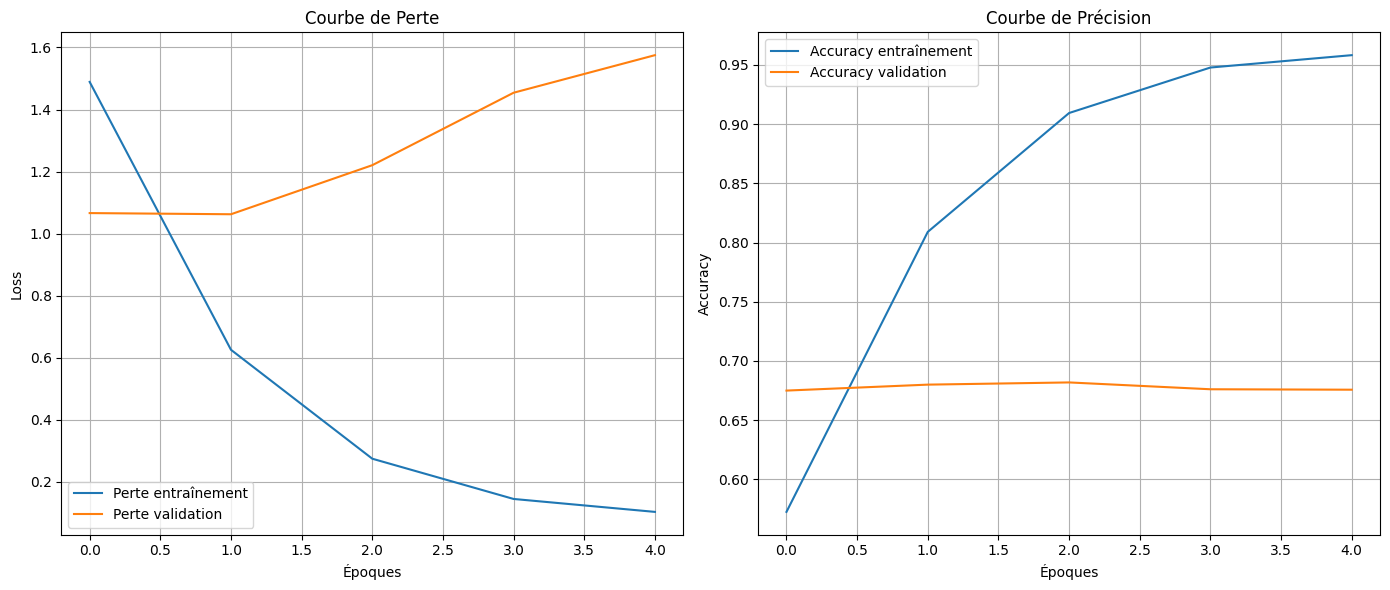

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


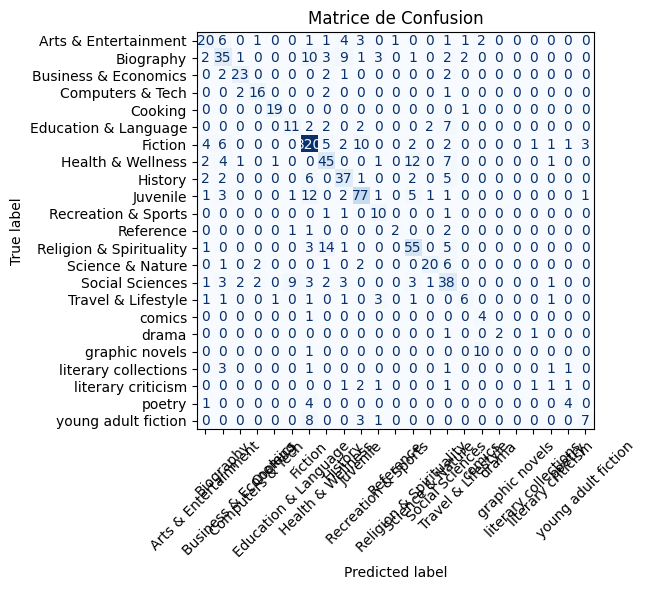

📊 **Métriques de classification sur les données de test**
 - Accuracy  : 0.6995
 - Precision : 0.6951
 - Recall    : 0.6995
 - F1-Score  : 0.6933
🏁 Fin du pipeline.


In [70]:
model = ModelClassifier_TFIDF_KERAS(csv_path="data/books_data.csv")
model.run_all(force_retrain=True)